In [21]:
import src.helper_func as hf
import numpy as np
import copy, cv2, math, os, sys
import pylab as pl

from sklearn.metrics import precision_score, accuracy_score, f1_score, recall_score

# Data load
data_07022022 = os.path.join('.', 'data', '07022022_data') # First dataset
data_04042022 = os.path.join('.', 'data', '04042022_data') # Second dataset

# images, labels = hf.load_tifdata(data_07022022, classes=2, label=True)
images, labels = hf.load_tifdata(data_04042022, classes=2, label=True, width=768, height=768)

Loaded (79) images from .\data\04042022_data


### Template extraction

#### Global Template Projection and Matching Method for Training-Free Analysis of Delayered IC Images

In [22]:
def load_filters(filter_path, count, shape):
    """
    0. Filters load 
    parameters \n
        filter_path -> file path for templates \n
        count -> count of templates to load \n
        shape -> shape of templates \n
    return \n
        templates \n
    """
    filters = np.loadtxt(filter_path).reshape(count, shape[0], shape[1])

    for i in range(1,len(filters) + 1): # Filters showing
        pl.subplot(4, 4, i)
        pl.imshow(filters[i-1], cmap="gray")
    pl.show()
    return filters

def template_expansion(filters, V, H):
    """
    1. Template expansion
    parameters \n
        filters -> template to expand \n
        V, H -> number of blocks 
    return \n
        reshape templates \n
    """
    templates = []
    for filter in filters:
        template = np.copy(filter)
        for lenght in range(V - 1):
            template = np.concatenate((template, filter), axis=0)
        filter_image = np.copy(template)
        for lenght in range(H - 1):
            template = np.concatenate((template, filter_image), axis=1)
        templates.append(template)
    return templates

def image_padding(image, N, M, n, m):
    """
    Add padding of image
    parameters \n
        image -> image \n
        N, M -> size of result image \n
        n, m -> size of image \n
    return \n
        padded image \n
    """
    image['img'] = np.pad(image['img'], (int((N - n) / 2),int((M - m) / 2)), 'constant', constant_values=(0))
    image['w'] = image['img'].shape[0]
    image['h'] = image['img'].shape[1]
    return image


def getM(X, Y, h):
    M = np.zeros((X, Y, h))
    for i in range(X):
        for j in range(Y):
            if i == j:
                M[i][j] = np.ones((h), dtype=int)
    return M

def global_matching(image, templates, N, H, w, V, M, h):
    """
    2. Global Matching
    parameters \n
        image -> image \n
        templates -> templates \n
    return \n
        score maps for image and templates \n
    """
    S = [] # score map
    M_r = getM(H, int(np.ceil(N/w)), w)
    M_r = M_r.reshape((H, N)).T

    M_l = getM(V, int(np.ceil(M/h)), h)
    M_l = M_l.reshape((V, M))

    for template in templates:
        s = np.sqrt((image - template) ** 2) # L2 distance
        S.append(np.dot(np.dot(M_l, s), M_r)) # local summation
    return S

def template_projection(templates, h, w): 
    """
    3. Template Projection
    parameters \n
        templates -> templates for projection \n
    return \n
        projected templates \n
    """
    T_xy = []
    for template in templates:
        for y in range(h):
            for x in range(w):
                template_xy = np.roll(template, -x, axis=0)
                template_xy = np.roll(template_xy, -y, axis=1)
                T_xy.append(template_xy)
    return T_xy

def global_template_projection_matching(image, templates, N, H, w, V, M, h):
    """
    4. Global Template Projection and Matching
    parameters \n
        image -> image to matching \n 
        templates -> projected templates  \n
    return \n
        projected score maps \n
    """
    S_xy = []
    M_r = getM(H, int(np.ceil(N/w)), w)
    M_r = M_r.reshape((H, N)).T

    M_l = getM(V, int(np.ceil(M/h)), h)
    M_l = M_l.reshape((V, M))
    
    for index, template in enumerate(templates):
        s = np.sqrt((image - template) ** 2) # L2 distance

        x = index % w
        y = index // w
        S_xy.append(
            np.dot(np.dot(np.roll(M_l, -y, axis=1), s), (np.roll(M_r, -x, axis=0)))
            ) # local summation
    return S_xy


def gtpm(shape, filter_path=os.path.join(".", "src", "filters_from_data.txt"), filter_shape=[3, [12, 12]], verbose=True):
    """
    Initialize GTPM, load templates and reshape them \n
    parameters \n
        shape -> shape of image \n
        filter_path -> path for templates \n
        filter_shape -> templates shape \n
    return \n
        expanded templates \n
    """
    if verbose: print(f"[+][0] Filter load")
    filters = load_filters(filter_path, filter_shape[0], filter_shape[1])

    m = shape[0]  # img_height
    n = shape[1]  # img_width
    if verbose: print("\timg_height {} img_width {}".format(m, n))

    h = filters[0].shape[0]  # flt_height
    w = filters[0].shape[1]  # flt_width
    if verbose: print("\tflt_height {} flt_width {}".format(h, w))

    V = int(np.ceil(m / h)) # block height
    H = int(np.ceil(n / w)) # block width
    if verbose: print("\tV(block height) {} H(block width) {}".format(V, H))

    M = h * V  # tmp_height
    N = w * H  # tmp_width
    if verbose: print("\ttmp_height {} tmp_width {}".format(M, N))

    if verbose: print("[+][1] Template projection")
    expanded_templates = template_projection(template_expansion(filters, V, H), h, w)

    return expanded_templates, N, H, w, V, M, h, n, m

def gtpm_prediction(image, expanded_templates, N, H, w, V, M, h, n, m):
    """
    Prediction for GTPM
    parameters \n
        image -> image \n
        expanded_templates -> expanded templates \n
    return \n
        aggregated score map \n
    """
    # Copy image and add padding
    image = copy.deepcopy(image)
    image = image_padding(image, N, M, n, m)

    # Compute Score maps (compute distance between template and input data)
    score_maps_xy = global_template_projection_matching(image['img'], expanded_templates, N, H, w, V, M, h)

    # Aggregate into one score maps
    result_map = np.zeros((V, H))
    for x in range(V):
        for y in range(H):
            min = np.iinfo(np.int32).max
            index_min = -1
            for index, score_map in enumerate(score_maps_xy):
                if min > score_map[x, y]:
                    min = score_map[x, y]
                    index_min = index
            result_map[x, y] = index_min 
    
    return result_map

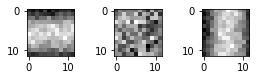

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


c:\Users\matho\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.6075949367088608, 0.0, 0.0, 0.0)

In [23]:
predictions = []
true_values = []

# Prepare GTPM 
expanded_templates, N, H, w, V, M, h, n, m = gtpm(images[0]['img'].shape, verbose=False)
# Prediction on every image
for image in images:
    # Prediction
    result = gtpm_prediction(image, expanded_templates, N, H, w, V, M, h, n, m)

    # A classification of which template is the most occur in the result score map
    horizontal_metal = np.sum(np.where(result <= 144, 1, 0))
    vias = np.sum(np.where((result > 144) & (result < 288), 1, 0))
    vertical_metal = np.sum(np.where(result >= 288, 1, 0))

    true_values.append(1 if image['Y'] > 0 else 0)
    predictions.append(1 if horizontal_metal > vias or vertical_metal > vias else 0)

# Print result of classification, print metrics of classification
print(predictions)
accuracy_score(true_values, predictions), f1_score(true_values, predictions), precision_score(true_values, predictions), recall_score(true_values, predictions)

### Thresholding approach

In [24]:
# Border for classification
border = 120 

####  New Iterative Triclass Thresholding Technique in Image Segmentation

In [25]:
from skimage.filters import threshold_otsu, threshold_niblack, threshold_sauvola, threshold_triangle
import numpy as np
import copy
import cv2


def triclass_threshold(image_dict, threshold_algorithm, preset_thresholding=3, F=None, B=None):
    """
    Iterative triclass thresholding technique
    parameters \n
        image_dict -> dict of image \n
        threshold_algorithm -> algorithm for thresholding (func) \n
        preset_thresholding -> preset thresholding to stop iterating \n
        F, B -> foreground and background pixel \n
    return \n
        segmentated image
    """
    result_image = copy.deepcopy(image_dict['img'])
    img = copy.deepcopy(image_dict['img'])

    thresholds = []
    index = 0
    while (1):
        # At the first iteration, Otsu’s method is applied to find a threshold T^[1]
        threshold = threshold_algorithm(img)
        thresholds.append(threshold)

        # We then find and denote the means of the two classes separated by T^[1]
        # as μ[1] 0 and μ[1] 1 for the background and foreground, respectively.
        first_class = img[img < int(threshold)]
        second_class = img[img > int(threshold)]
        
        # The iteration stops when the difference between two consecutive threshold 
        # |T^[n+1] − T^[n]| is less than a preset threshold.
        if index > 0 and ((abs(thresholds[index-1] - thresholds[index-2]) < abs(thresholds[index] - thresholds[index-1])) or (abs(thresholds[index-1] - thresholds[index-2]) <= preset_thresholding)):
            B = np.concatenate((B, img[img < int(threshold)]), axis=None)
            F = np.concatenate((F, img[img > int(threshold)]), axis=None)
            result_image = np.where(np.isin(result_image, img[img > int(threshold)]), 1, result_image)
            result_image = np.where(result_image == 1, 1, 0)
            break

        mi_0 = np.mean(first_class)
        mi_1 = np.mean(second_class)

        # Then we classify regions whose pixel values are greater than μ_1 as foreground F^[1] 
        # and regions whose pixel values are less than μ_0 as background B^[1]
        B = np.concatenate((B, first_class[first_class < mi_0]), axis=None)
        F = np.concatenate((F, second_class[second_class > mi_1]), axis=None)
        result_image = np.where(np.isin(result_image, second_class[second_class > mi_1]), 1, result_image)

        TBD = img[(mi_0 <= img) & (img <= mi_1)] # omega

        # At the second iteration, we apply Otsu’s method to find threshold T^[2]
        # on region omega[1] only.
        img = TBD
        index += 1
    # print(f"Number of iteration {index}")
    return result_image

#### Triangle Iterative Triclass thresholding

In [26]:
true_values = []
predictions = []

# Prediction on every image
for image in images:
    result = triclass_threshold(image, threshold_triangle)

    true_values.append(1 if image['Y'] > 0 else 0)
    predictions.append(hf.classification_var(result, verbose=False, border=border))

# Print result of classification, print metrics of classification
print(predictions)
accuracy_score(true_values, predictions), f1_score(true_values, predictions), precision_score(true_values, predictions), recall_score(true_values, predictions)

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


(0.810126582278481, 0.6938775510204082, 0.9444444444444444, 0.5483870967741935)

#### Otsu Iterative Triclass thresholding

In [27]:
true_values = []
predictions = []

# Prediction on every image
for image in images:
    result = triclass_threshold(image, threshold_otsu)

    true_values.append(1 if image['Y'] > 0 else 0)
    predictions.append(hf.classification_var(result, verbose=False, border=border))

# Print result of classification, print metrics of classification
print(predictions)
accuracy_score(true_values, predictions), f1_score(true_values, predictions), precision_score(true_values, predictions), recall_score(true_values, predictions)

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


(0.9113924050632911, 0.8852459016393444, 0.9, 0.8709677419354839)

#### Niblack thresholding

In [28]:
true_values = []
predictions = []

# Prediction on every image
for image in images:
    result = image['img'] > threshold_niblack(image['img'], window_size=25, k=0.8)
    
    true_values.append(1 if image['Y'] > 0 else 0)
    predictions.append(hf.classification_var(result, verbose=False, border=border))

# Print result of classification, print metrics of classification
print(predictions)
accuracy_score(true_values, predictions), f1_score(true_values, predictions), precision_score(true_values, predictions), recall_score(true_values, predictions)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


(0.620253164556962, 0.16666666666666666, 0.6, 0.0967741935483871)

#### Sauvola thresholding

In [29]:
true_values = []
predictions = []

# Prediction on every image
for image in images:
    result = image['img'] > threshold_sauvola(image['img'], window_size=25)
    
    true_values.append(1 if image['Y'] > 0 else 0)
    predictions.append(hf.classification_var(result, verbose=False, border=border))

# Print result of classification, print metrics of classification
print(predictions)
accuracy_score(true_values, predictions), f1_score(true_values, predictions), precision_score(true_values, predictions), recall_score(true_values, predictions)

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


(0.8607594936708861,
 0.7999999999999999,
 0.9166666666666666,
 0.7096774193548387)

### Deep Learning for Automatic IC Image Analysis

In [54]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.python.client import device_lib
import tensorflow

sess = tensorflow.compat.v1.Session(config=tensorflow.compat.v1.ConfigProto(log_device_placement=True))

# # LOAD DATASETS
images, labels = hf.load_tifdata(data_07022022, classes=2, label=True)
# images, labels = hf.load_tifdata(data_04042022, classes=2, label=True, width=768, height=768)

x, y = [], []
for index, data in enumerate(images):
    x.append(data['img'])
    y.append(data['Y'])

# # SPLIT INTO valid train
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=1)
# x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.50, random_state=1) 

# ------------------------------------------
# # Divide dataset into small images
image_size = 128 # Size of images
x_split, y_split = [], []
for item_x, item_y in zip(x_train, y_train):
    cropped_image = hf.crop_image(item_x, image_size, image_size)
    x_split += cropped_image
    y_split += [item_y for item in range(len(cropped_image))]
x_train = np.array([item.reshape(item.shape[1], item.shape[0], 1) for item in x_split])
y_train = np.array(y_split)

x_split, y_split = [], []
for item_x, item_y in zip(x_test, y_test):
    cropped_image = hf.crop_image(item_x, image_size, image_size)
    x_split += cropped_image
    y_split += [item_y for item in range(len(cropped_image))]
x_test = np.array([item.reshape(item.shape[1], item.shape[0], 1) for item in x_split])
y_test = np.array(y_split)

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:26:00.0, compute capability: 8.6

Loaded (42) images from .\data\07022022_data


#### Model definition

In [57]:
import keras
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
import tensorflow_addons as tfa

batch_size = 100
epochs = 20
num_classes = 2
shape = x_train[0].shape
# Architecture
model = tf.keras.applications.ResNet50(
    include_top=True,
    weights=None,
    input_tensor=keras.layers.Input(shape=shape),
    input_shape=shape,
    pooling=max,
    classes=num_classes,
    classifier_activation="softmax",
)

# Optimalizer
optimalizer = tf.keras.optimizers.Adam(
    learning_rate=0.001, 
    beta_1=0.9, 
    beta_2=0.999, 
    epsilon=1e-07, 
    amsgrad=False, 
    name='Adam'
)

# Compile with Optimalizer, Metrics (accuracy), Categorical Crossentropy
model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(), 
    optimizer=optimalizer,
    metrics=['accuracy']
    )

# Train model
history = model.fit(
    x_train,
    to_categorical(y_train),
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(x_test, to_categorical(y_test)),
    shuffle='batch',
    use_multiprocessing=True, 
    workers=8
)

# Evaluate
model.evaluate(x_test, to_categorical(y_test), verbose=1)

Epoch 1/20
22/22 [==============================] - 8s 223ms/step - loss: 4.0193 - accuracy: 0.3887 - val_loss: 99.8373 - val_accuracy: 0.2222
Epoch 2/20
22/22 [==============================] - 4s 169ms/step - loss: 1.0898 - accuracy: 0.5407 - val_loss: 32.5642 - val_accuracy: 0.2222
Epoch 3/20
22/22 [==============================] - 4s 168ms/step - loss: 1.5270 - accuracy: 0.5573 - val_loss: 4.2399 - val_accuracy: 0.2222
Epoch 4/20
22/22 [==============================] - 4s 178ms/step - loss: 0.7193 - accuracy: 0.6804 - val_loss: 6.2690 - val_accuracy: 0.2222
Epoch 5/20
22/22 [==============================] - 4s 175ms/step - loss: 0.5823 - accuracy: 0.7296 - val_loss: 4.0220 - val_accuracy: 0.2222
Epoch 6/20
22/22 [==============================] - 4s 166ms/step - loss: 0.7333 - accuracy: 0.6785 - val_loss: 8.3007 - val_accuracy: 0.2222
Epoch 7/20
22/22 [==============================] - 4s 163ms/step - loss: 0.4881 - accuracy: 0.7481 - val_loss: 5.9844 - val_accuracy: 0.2222
Epoc

[0.8643131852149963, 0.2222222238779068]

#### Get prediction for whole dataset including other class

In [56]:
images, labels = hf.load_tifdata(data_04042022, classes=2, label=True, width=768, height=768)
# images, labels = hf.load_tifdata(data_07022022, classes=2, label=True)
x, y = [], []
for index, data in enumerate(images):
    x.append(data['img'])
    y.append(1 if data['Y'] else 0)

# # Divide dataset into small images
x_split, y_split = [], []
for item_x, item_y in zip(x, y):
    cropped_image = hf.crop_image(item_x, image_size, image_size)
    x_split += cropped_image
    y_split += [item_y for item in range(len(cropped_image))]
cropped_len = len(cropped_image)
x = np.array([item.reshape(item.shape[1], item.shape[0], 1) for item in x_split])
y = np.array(y_split)

np.set_printoptions(threshold=sys.maxsize)
result = []
predictions = np.argmax(model.predict(x), axis=1)
for item in range(0, len(predictions)//cropped_len):
    result.append(np.sum(predictions[item*cropped_len: (item+1)*cropped_len]))
predictions = [1 if item > 0 else 0 for item in result]


# Print result of classification, print metrics of classification
print(predictions)
accuracy_score(labels, predictions), f1_score(labels, predictions), precision_score(labels, predictions), recall_score(labels, predictions)

Loaded (79) images from .\data\04042022_data
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


(0.2911392405063291,
 0.45098039215686275,
 0.323943661971831,
 0.7419354838709677)

In [62]:
predictions = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]

# images, labels = hf.load_tifdata(data_04042022, classes=3, label=True, width=768, height=768)
images, labels = hf.load_tifdata(data_07022022, classes=3, label=True)
labels = [1 if item > 0 else 0 for item in labels]
# images, labels = hf.load_tifdata(data_07022022, classes=2, label=True)
accuracy_score(labels, predictions), f1_score(labels, predictions), precision_score(labels, predictions), recall_score(labels, predictions)

Loaded (100) images from .\data\07022022_data


(0.79, 0.8826815642458101, 0.79, 1.0)

### Clustering approach

In [30]:
# Border for classification
border = 120

#### Classic k-means for segmentation

In [15]:
def km_clust(array, clusters, iteration=10):
    """
    Wrap k-means from opencv
    parameters \n
        array -> array to cluster \n
        clusters -> number of clusters \n
        iteration -> number of iteration for clustering \n
    return \n
        labels and centroids
    """
    X = np.float32(array.reshape((-1, 1)))

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.85)

    values, labels, centers = cv2.kmeans(X, clusters, None, criteria, iteration, cv2.KMEANS_RANDOM_CENTERS)
    return (centers, labels)
    
def kmeans_cls(img, clustes=2):
    """
    Use k-means to clustering pixel in image
    parameters \n
        img -> image to segmentent \n
        clusters -> number of clusters (default 2) \n
    return \n
        segmentated image
    """
    values, labels = km_clust(img, clusters=clustes)

    # Create the segmented array from labels and values
    img_segm = np.choose(labels, values)

    # Reshape the array as the original image
    img_segm.shape = img.shape

    result = np.where(img_segm == values[0], 1, 0)
    return result


In [31]:
predictions = []
true_values = []

# Prediction on every image
for image in images:
    result = kmeans_cls(image['img'], 2)
    
    true_values.append(1 if image['Y'] > 0 else 0)
    predictions.append(hf.classification_var(result, border=border, verbose=False))

# Print result of classification, print metrics of classification
print(predictions)
accuracy_score(true_values, predictions), f1_score(true_values, predictions), precision_score(true_values, predictions), recall_score(true_values, predictions)

[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


(0.8987341772151899,
 0.8709677419354839,
 0.8709677419354839,
 0.8709677419354839)

#### Classic k-means

In [32]:
from sklearn.cluster import MiniBatchKMeans

x, y = [], []
# Load data into one array for clustering
for index, data in enumerate(images):
    x.append(np.array(data['img']).reshape(data['h'] * data['w']))
    y.append(1 if data['Y'] > 0 else 0)

X = np.array(x)
y = np.array(y)

# Get count of clusters
total_clusters = len(np.unique(y))
# Clustering from scikit-learn
kmeans = MiniBatchKMeans(n_clusters = total_clusters)
kmeans.fit(X)

# Print result
prediction = kmeans.labels_
accuracy_score(true_values, predictions), f1_score(true_values, predictions), precision_score(true_values, predictions), recall_score(true_values, predictions)

c:\Users\matho\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:887: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


(0.8987341772151899,
 0.8709677419354839,
 0.8709677419354839,
 0.8709677419354839)

#### Adaptive k-means clustering algorithm for MR breast image segmentation

In [33]:
# Initialization phase 
iteration = 10

def fcir(areas, clusters):
    """
    Compute fcir function
    parameters \n
        areas -> pixels of image \n
        clusters -> value of cluster for pixel \n
    """
    return ((areas * 4 * math.pi) / np.power(clusters, 2))

def goodness(areas, clusters):
    """
    Compute goodness function
    parameters \n
        areas -> pixels of image \n
        clusters -> value of cluster for pixel \n
    """
    sum_fcir = np.sum(fcir(areas, clusters) * areas)
    sum_areas = np.sum(areas)
    return sum_fcir/sum_areas

def kmeans_(array, clusters=2, iteration=10, centers=cv2.KMEANS_RANDOM_CENTERS):
    """
    Wrap k-means from opencv
    parameters \n
        array -> array to cluster \n
        clusters -> number of clusters \n
        iteration -> number of iteration for clustering \n
        centers -> if centroid shoudl be random or predifined \n
    return \n
        labels and centroids
    """
    X = np.float32(array.reshape((-1, 1)))
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.85)

    if type(centers) is np.ndarray:
        values, labels, centers = cv2.kmeans(X, clusters, None, criteria, iteration, cv2.KMEANS_USE_INITIAL_LABELS, centers)
    else:
        values, labels, centers = cv2.kmeans(X, clusters, None, criteria, iteration, centers)
    return (centers, labels)

def new_center_generation(centers):
    """
    Create new centroid 
    parameters \n
        centers -> previous centers
    return \n
        new centers
    """
    # Define the brightest centroid
    x = centers[1] if centers[1] > centers[0] else centers[0]
    y = centers[0] if centers[1] > centers[0] else centers[1]
    # Compute distance from old
    distance = x - y

    # Get random value
    random_value = np.random.rand(1)[0]

    # Compute new centroid
    z = x + distance * random_value
    w = x - distance * random_value
    return np.array([z, w])

def adaptive_kmeans(img, clusters=2, iteration=10, itstop=5):
    """
    Adaptive k-means for pixel segmentation
    parameters \n
        img -> image for segmentation \n
        clusters -> number of clusters \n
        iteration -> number of iteration for clustering \n
        itstop -> number of iteration for whole process
    return \n
        segmentated image
    """
    # First get starting centroid
    values, labels = kmeans_(img, clusters=clusters, iteration=iteration)

    img_re = img.reshape((img.shape[0] * img.shape[1], 1))
    img_segm = np.choose(labels, values)
    
    # Get starting goodness 
    goodness_prev = goodness(img_re, img_segm)
    clusters_prev = values

    # Iterative use k-means
    for index in range(itstop):
        # K-means
        values, labels = kmeans_(img, clusters=clusters, iteration=iteration, centers=clusters_prev)
        img_segm = np.choose(labels, values)

        # Compute goodness 
        goodness_val = goodness(img_re, img_segm)
        # Choose new centroids
        if goodness_val <= goodness_prev:
            goodness_prev = goodness_val
            clusters_prev = values
        else:
            values = new_center_generation(values)

    img_segm.shape = img.shape
    result = np.where(img_segm == values[0], 0, 1)
    return result


In [34]:
predictions = []
true_values = []

# Prediction on every image
for image in images:
    result = adaptive_kmeans(image['img'], 2)

    true_values.append(1 if image['Y'] > 0 else 0)
    predictions.append(hf.classification_var(result, border=border, verbose=False))

# Print result of classification, print metrics of classification
print(result)
accuracy_score(true_values, predictions), f1_score(true_values, predictions), precision_score(true_values, predictions), recall_score(true_values, predictions)

[[0 0 1 ... 1 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 0 1]
 [1 1 1 ... 1 1 0]
 [0 1 0 ... 1 0 0]]


(0.8734177215189873,
 0.8148148148148149,
 0.9565217391304348,
 0.7096774193548387)

# .